In [2]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
def read_csv_files():
    base_path = '../data/stock/'
    all_files = glob.glob(os.path.join(base_path, "*.csv"))
    
    df_list = []
    
    for file_path in all_files:
        ticker = os.path.splitext(os.path.basename(file_path))[0]
        df = pd.read_csv(file_path, parse_dates=['date'])

        # 최소 1년치 데이터 보유 시에만 추가
        if len(df) >= 252:  
            df['ticker'] = ticker   # 티커 컬럼 추가
            df.drop([
                'adjClose', 'adjHigh', 'adjLow', 'adjOpen',
                'adjVolume', 'divCash', 'splitFactor'
            ], axis=1, inplace=True)
            df_list.append(df)
    return df_list

In [4]:
def find_shortest_period(df_list):
    min_dates = []
    max_dates = []

    for df in df_list:
        min_dates.append(df['date'].min())
        max_dates.append(df['date'].max())

    # 모든 종목이 공통으로 갖는 기간
    start_date = max(min_dates)
    end_date = min(max_dates)
    return start_date, end_date

In [5]:
def same_period(df_list, start_date, end_date):
    trimmed_list = []

    for df in df_list:
        mask = (df['date'] >= start_date) & (df['date'] <= end_date)
        trimmed_df = df.loc[mask].copy()
        trimmed_list.append(trimmed_df)
    return trimmed_list

In [6]:
def extract_features(df):

    
    def calculate_rsi(series, period=14):
        delta = series.diff()  # 하루 전 대비 가격 변화량
        # 상승폭 평균(오른 날은 양수, 내린 날은 0으로 처리)
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        # 하락폭 평균(내린 날은 양수, 오른 날은 0으로 처리)
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / loss  # 상대 강도
        rsi = 100 - (100 / (1 + rs))  # RSI 공식
        return rsi


    def calculate_mdd(series):
        roll_max = series.cummax()  # 누적 최고가 시계열
        drawdown = (series - roll_max) / roll_max
        mdd = drawdown.min()
        return mdd


    def calc_6m_features(df):
        df_6m = df.tail(126)
        ma_6m = df_6m['close'].mean()
        ret_6m = (df_6m['close'].iloc[-1] / df_6m['close'].iloc[0]) - 1
        # 최근 6개월 변동성 (로그수익률 표준편차 × sqrt(252)로 연환산)
        logret = np.log(df_6m['close'] / df_6m['close'].shift(1)).dropna()
        vola_6m = logret.std() * np.sqrt(252)  # 연율화
        return ma_6m, ret_6m, vola_6m

    
    ticker = df['ticker'].unique()[0]
    ma60 = df['close'].rolling(window=60).mean().iloc[-1]  # 60일 이동평균
    ret = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1  # 전체 기간 수익률
    vola = df['close'].pct_change().rolling(window=30).std().mean()  # 30일 변동성
    rsi = calculate_rsi(df['close'], 14).iloc[-1]
    mdd = calculate_mdd(df['close'])
    avg_vol = df['volume'].mean()  # 평균 거래량

    ma_6m, ret_6m, vola_6m = calc_6m_features(df)  # 최근 6개월 이동평균, 수익률, 변동성
    
    return [ticker, ma60, ma_6m, ret, ret_6m, vola, vola_6m, rsi, mdd, avg_vol]

In [7]:
def make_feature_df(df_list):
    feature_names = [
        'Ticker', 'MA_60', 'MA_6M', 'Total_Return', 'Return_6M', 
        'Vol_30', 'Vol_6M', 'RSI_14', 'MDD', 'Avg_Volume'
    ]
    features_list = []

    for df in df_list:
        feats = extract_features(df)
        features_list.append(feats)

    features_df = pd.DataFrame(features_list, columns=feature_names)
    features_df.set_index('Ticker', inplace=True)
    return features_df

In [8]:
# Elbow Method
def optimization_k(df):
    inertias = []  # SSE
    
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)
    
    plt.plot(range(1, 11), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia (Within-cluster sum of squares)')
    plt.show()

    # 엘보우 포인트 자동 탐지 함수
    def find_elbow_point(x, y):
        x1, y1 = x[0], y[0]
        x2, y2 = x[-1], y[-1]
        distances = []
        for i in range(len(x)):
            numerator = abs((y2 - y1)*x[i] - (x2 - x1)*y[i] + x2*y1 - y2*x1)
            denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            distances.append(numerator / denominator)
        return np.argmax(distances) + 1  # +1은 K가 1부터 시작할 때
    
    optimal_k = find_elbow_point(np.array(list(range(1, 11))), np.array(inertias))
    print(f"엘보우 포인트(최적 K): {optimal_k}")

    return optimal_k

In [9]:
def k_means():
    df_list = read_csv_files()
    start_date, end_date = find_shortest_period(df_list)
    trimmed_list = same_period(df_list, start_date, end_date)
    df = make_feature_df(trimmed_list)
    df = df.dropna()    # 결측치 제거

    # 표준화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # K-Means 클러스터링
    k = optimization_k(X_scaled)
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    df.loc[:, 'Cluster'] = clusters
    
    # 2차원 시각화
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
    plt.title('K-Means Clustering of Stocks (PCA Visualization)')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    # 클러스터링 평가 지표
    print("실루엣 계수:", silhouette_score(X_scaled, clusters)) # 실루엣 계수
    print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, clusters)) # Davies-Bouldin Index
    print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, clusters))  # Calinski-Harabasz Index

C:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

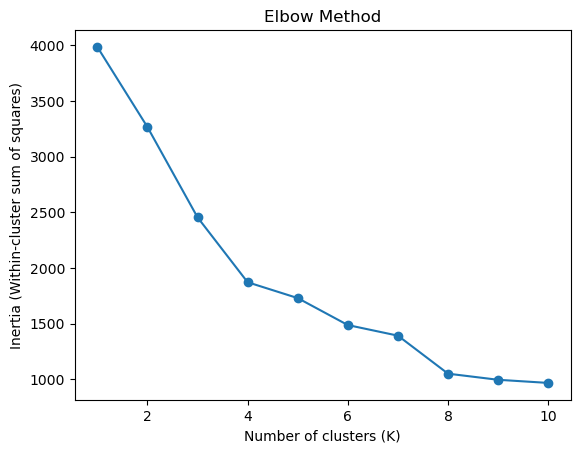

엘보우 포인트(최적 K): 4


C:\Users\kdh80\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


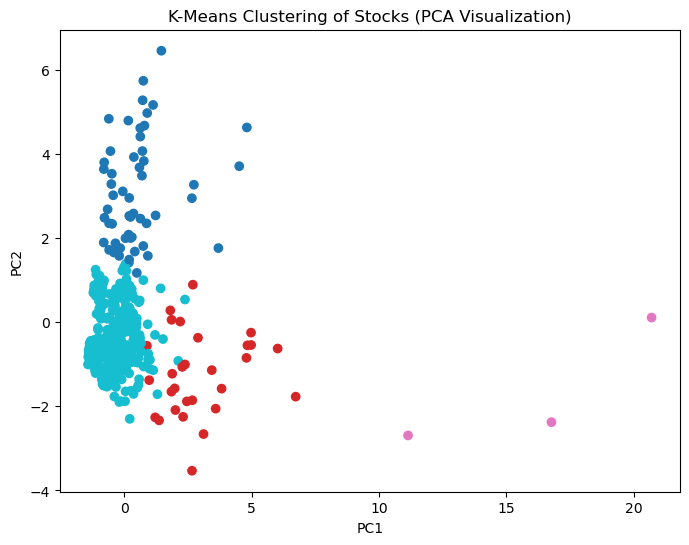

실루엣 계수: 0.49023068653347185
Davies-Bouldin Index: 0.9243586494906965
Calinski-Harabasz Index: 165.2348784610926


In [10]:
k_means()